## Sagnac Frequency - Backscatter Correction - Mulit-Regression Model

Explore the longterm behaviour of the RU sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.load_beam_wander_data import __load_beam_wander_data
from functions.reduce import __reduce

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

# hardly jumps or splits
# config['tbeg'] = UTCDateTime("2024-03-26 12:00")
# config['tend'] = UTCDateTime("2024-03-31 00:00")
# flim1, flim2 = 302.42, 302.50

# # splits
# config['tbeg'] = UTCDateTime("2024-03-28 12:00")
# config['tend'] = UTCDateTime("2024-03-30 21:00")
# flim1, flim2 = 302.40, 302.48

#
# config['tbeg'] = UTCDateTime("2024-03-31 18:00")
# config['tend'] = UTCDateTime("2024-04-03 00:00")
# flim1, flim2 = 302.42, 302.50


## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"


config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

In [4]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

In [66]:
def __makeplot_corr_matrix(ddf, target, m="pearson"):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    _df = ddf.copy()

    if "time" in list(_df.columns):
        _df.drop(columns="time", inplace=True)

    _df = _df.iloc[:, :]

    corr = _df.corr(method=m)

    # mask upper triangle
    corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

    print(corr)

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
    cmap = plt.get_cmap("coolwarm", 9)

    # Generate a mask for the upper triangle
    # mask = np.zeros_like(corr, dtype=bool)
    # mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    # sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

    im = plt.pcolor(corr, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    plt.colorbar(im, extend="both")

    labels = list(corr.columns)
    ax = plt.gca()
    ax.set_xticks(np.arange(len(labels))+0.5)
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(len(labels))+0.5)
    ax.set_yticklabels(labels)


    fig.suptitle(f'{m} correlation matrix', fontsize=15)

    fig.tight_layout();

    return fig

In [7]:
def __find_model(ddf, _features, target="fj_fs", reg="theilsen"):

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    # define x data
    X = _df[_features].values.reshape(-1, len(_features))

    # define y data
    y = _df[target].values

    # multi linear regression

    # using OLS
    if reg.lower() == "ols":
        ols = linear_model.LinearRegression()
        model = ols.fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)

    elif reg.lower() == "ransac":
        model = RANSACRegressor(random_state=1).fit(X, y)
        print("R2:", model.score(X, y))

    # using TheilSen
    elif reg.lower() == "theilsen":
        model = TheilSenRegressor().fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    out = {}
    out['model'] = model
    out['r2'] = model.score(X, y)
    out['tp'] = _df.time
    out['dp'] = model_predict

    return out

In [8]:
def __predict_data(ddf, _features, model, target="fj_fs"):

    from numpy import array

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    return array(_df.time), array(model_predict)

In [16]:
def __makeplot(df0, modell, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df[target], color="k", label="observed")
    ax.plot(df0.time*tscale, modell['dp'], color="tab:red", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=4, fontsize=font-2)

    ax.set_ylabel(f"$\Delta$f (Hz)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={modell['r2']:.2f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(min(df0.time*tscale), max(df0.time*tscale))

    ax.set_title(target)

    plt.show();
    return fig

In [86]:
def __makeplot2(df0, df1, tp, dp, model, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 4), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df0[target], color="k", label="observed (training)", alpha=0.7)
    ax.plot(model['tp']*tscale, model['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax.fill_betweenx([-1000, 1000], df0.time.min()*tscale, df0.time.max()*tscale, color="grey", alpha=0.3)

    ax.plot(df1.time*tscale, df1[target], color="k", label="observed")
    ax.plot(tp*tscale, dp, color="darkred", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=8, fontsize=font-2, ncol=2)

    ax.set_ylabel(f"Displacement ($\mu$m)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={out['r2']:.3f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(0, df1.time.max()*tscale)

    if target == "bwy":
        ax.set_ylim(-10, 55)
    if target == "bwx":
        ax.set_ylim(-2, 5)

    ax.set_title(target)

    plt.show();
    return fig

### Read Dataframe

In [11]:
# os.listdir(config['path_to_out_data'])

In [12]:
df = read_pickle(config['path_to_out_data']+"multi_regression_df2.pkl")

In [13]:
# df.plot(x="time", y=list(df.columns), subplots=True, figsize=(15, 10))

### add Hilbert Transfrom of Air Pressure

In [23]:
df['hp'] = np.imag(hilbert(df.bdo))

### convert displacement

In [71]:
df['bwx'] *= 1e3 # to micro meter
df['bwy'] *= 1e3 # to micro meter

### Define features

In [72]:
# specify target column
targetx = 'fj_bs'

# create list for features
# features = list(df.columns)
features = ['time', targetx, 'bwx', 'bwy', 'bdo', 'ps9', 'ps5', 'ps1', 'mae', 'man']

dfx = df[features]

out = __find_model(dfx, features, target=targetx, reg="theilsen")


R2: 0.23185574627536143
X0: 0.031289035553346625
Coef:  [-3.47497701e-03  1.70053199e-03  8.69261892e-02  7.85487514e-02
 -5.44881913e-02  2.65844738e-01  2.32541710e+04  4.55417846e+02]


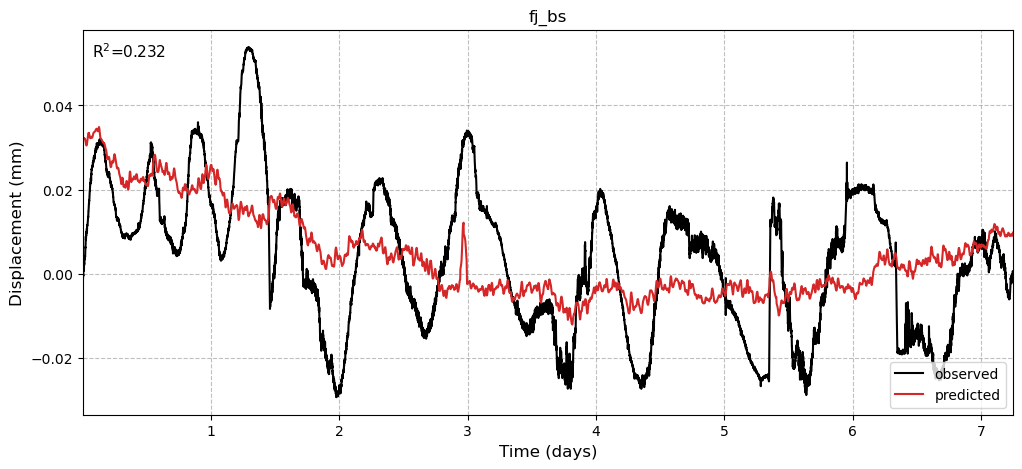

In [73]:
fig = __makeplot(dfx, out, targetx);

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_shortterm_model_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')


       fj_bs     bwx       bwy       bdo       ps9       ps5       ps1  \
fj_bs    NaN -0.1493 -0.437177  0.445753  0.477715  0.462853  0.438040   
bwx      NaN     NaN -0.052898 -0.139758 -0.250689 -0.011820  0.134260   
bwy      NaN     NaN       NaN -0.955547 -0.926575 -0.974126 -0.907367   
bdo      NaN     NaN       NaN       NaN  0.925682  0.901296  0.801034   
ps9      NaN     NaN       NaN       NaN       NaN  0.943307  0.822650   
ps5      NaN     NaN       NaN       NaN       NaN       NaN  0.928762   
ps1      NaN     NaN       NaN       NaN       NaN       NaN       NaN   
mae      NaN     NaN       NaN       NaN       NaN       NaN       NaN   
man      NaN     NaN       NaN       NaN       NaN       NaN       NaN   

            mae       man  
fj_bs  0.444296  0.482425  
bwx    0.104244 -0.293356  
bwy   -0.989942 -0.897544  
bdo    0.916596  0.870764  
ps9    0.900460  0.962422  
ps5    0.983174  0.948782  
ps1    0.935115  0.843291  
mae         NaN  0.897388  
man    

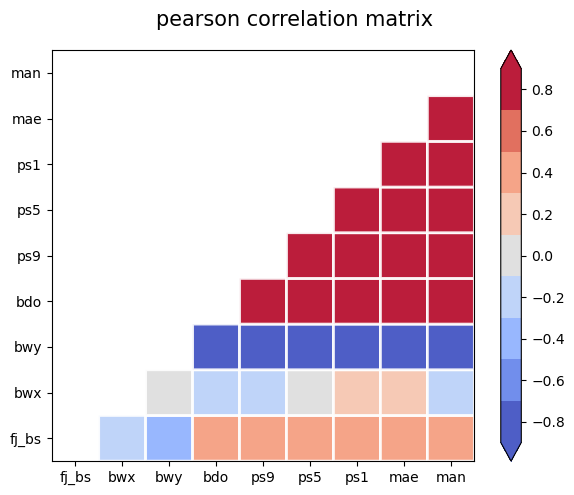

In [74]:
fig = __makeplot_corr_matrix(dfx, targetx, m="pearson")

# fig.savefig(config['path_to_figs']+f"BW_ccmatrix_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')


## Modelling

### Beam Wander

In [75]:
def __makeplot(df0, modell, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df0[target], color="k", label="observed")
    ax.plot(modell['tp']*tscale, modell['dp'], color="tab:red", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=4, fontsize=font-2)

    ax.set_ylabel(f"Displacement (mm)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={modell['r2']:.3f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(min(df0.time*tscale), max(df0.time*tscale))

    ax.set_title(target)

    plt.show();
    return fig

In [76]:

features = ['time', 'bwx', 'bwy', 'bdo', 'ps1', 'ps5', 'ps9', 'mae', 'man']

df1 = df[features]

target = "bwy"

N = df1.shape[0]

df1_part1 = df1.iloc[:int(N/2)]
df1_part2 = df1.iloc[int(N/2):]

out = __find_model(df1, features, target=target, reg="ransac")

t_predict, d_predict = __predict_data(df1_part2, features, out['model'], target=target)


R2: 0.9971416413934323


     bwx       bwy       bdo       ps1       ps5       ps9       mae       man
bwx  NaN  0.718591 -0.596897 -0.609270 -0.755046 -0.747143 -0.777348 -0.766330
bwy  NaN       NaN -0.694468 -0.631684 -0.886021 -0.870847 -0.900692 -0.903620
bdo  NaN       NaN       NaN  0.441110  0.606721  0.598839  0.646239  0.614969
ps1  NaN       NaN       NaN       NaN  0.659799  0.660196  0.656276  0.661222
ps5  NaN       NaN       NaN       NaN       NaN  0.929434  0.935849  0.962696
ps9  NaN       NaN       NaN       NaN       NaN       NaN  0.917594  0.938049
mae  NaN       NaN       NaN       NaN       NaN       NaN       NaN  0.949412
man  NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN


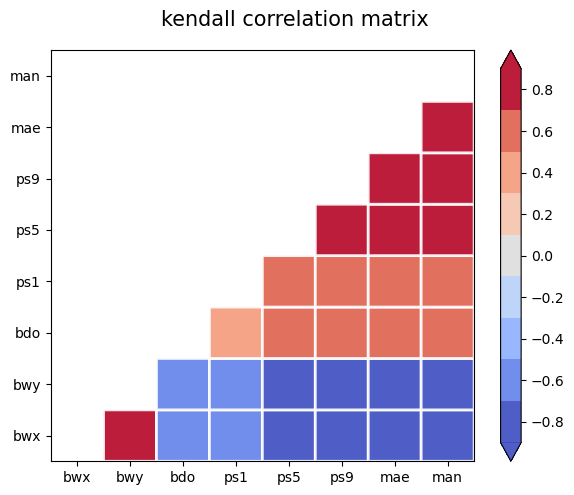

In [77]:
fig = __makeplot_corr_matrix(df1_part1, target, m="kendall")

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_beamwander_{target}_ccmatrix.png", format="png", dpi=150, bbox_inches='tight')


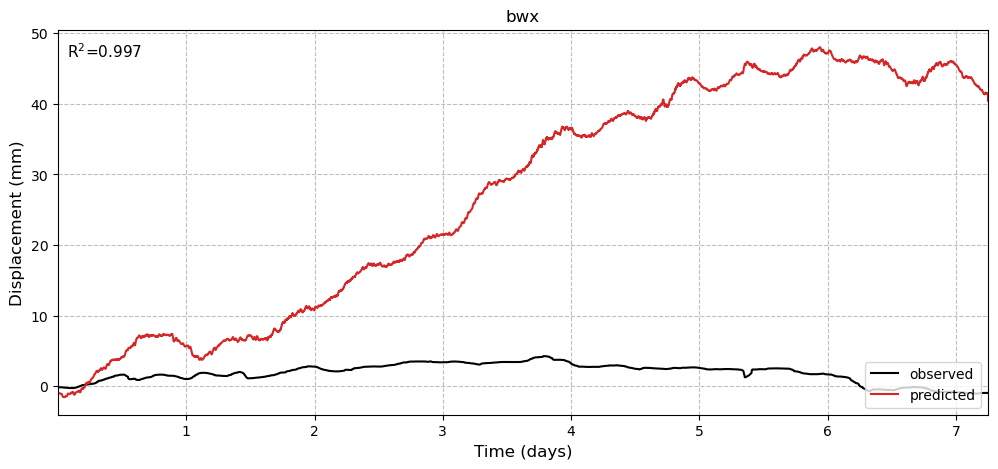

In [84]:
fig = __makeplot(df1, out, target)

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_beamwander_{target}_predicted.png", format="png", dpi=150, bbox_inches='tight')


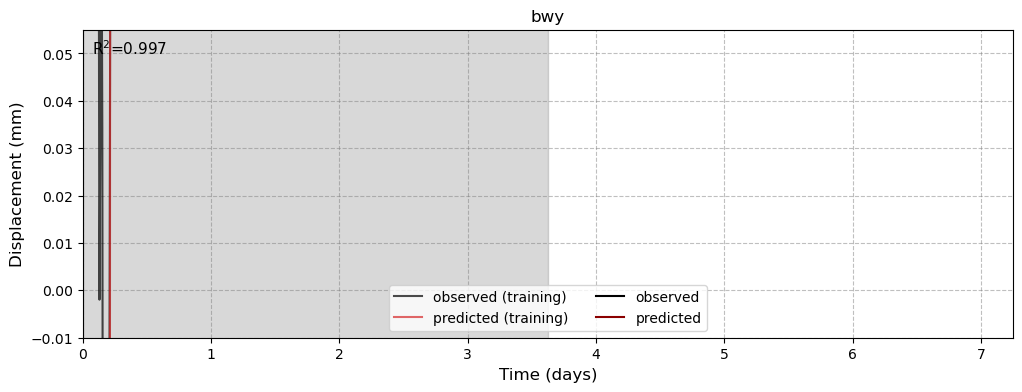

In [79]:
fig = __makeplot2(df1_part1, df1_part2, t_predict, d_predict, out, target);

In [80]:
# # tbeg, tend = UTCDateTime(df1.time.min()), UTCDateTime(df1.time.max())
# tbeg = UTCDateTime("2024-04-20 18:00")
# tend = UTCDateTime("2024-04-30 00:00")

# bw = __load_beam_wander_data(tbeg.date, tend.date, data_path+"ids/data/")

# bw = bw[(bw.time > tbeg) & (bw.time < tend)]

# bw.time_utc = np.array([UTCDateTime(_t) for _t in bw.time])

# bw['x_mm'] = bw.x*1.67e-3
# bw['y_mm'] = bw.y*1.67e-3

# bw['x_mm'] = __reduce(bw.x_mm, 10)
# bw['y_mm'] = __reduce(bw.y_mm, 10)


## Both Components

R2: 0.9632053292388598
     bwx       bwy       ps1       ps5       ps9
bwx  NaN  0.718591 -0.609270 -0.755046 -0.747143
bwy  NaN       NaN -0.631684 -0.886021 -0.870847
ps1  NaN       NaN       NaN  0.659799  0.660196
ps5  NaN       NaN       NaN       NaN  0.929434
ps9  NaN       NaN       NaN       NaN       NaN


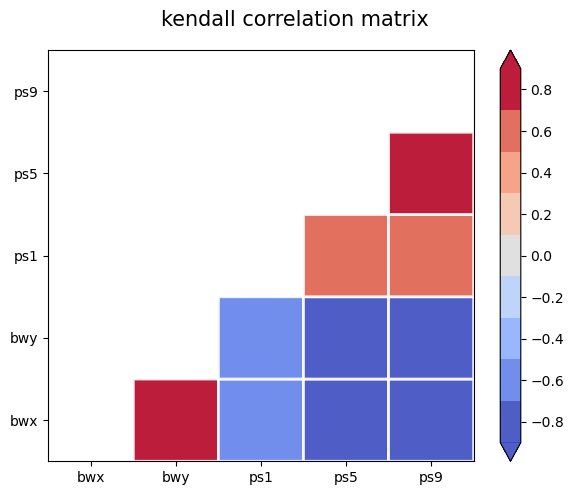

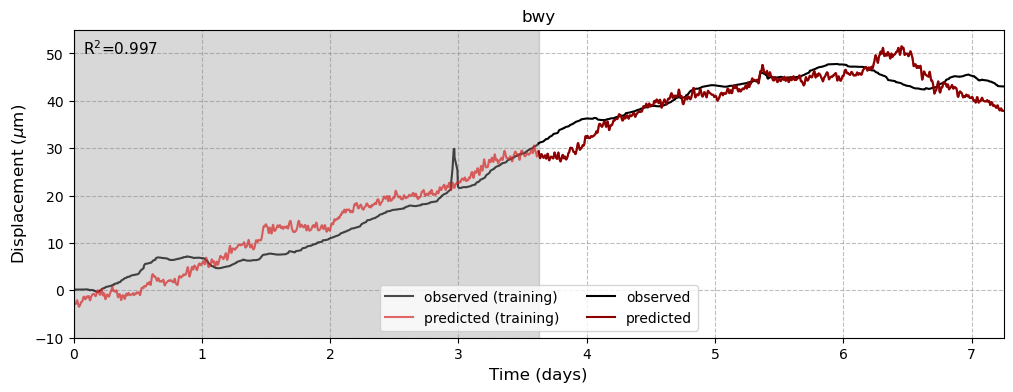

bwx :  -2.07
ps1 :  -17.96
ps5 :  -52.69
ps9 :  -53.78
y0:  -3.16
R2: 0.49088270149152
     bwx       bwy       ps1       ps5       ps9
bwx  NaN  0.718591 -0.609270 -0.755046 -0.747143
bwy  NaN       NaN -0.631684 -0.886021 -0.870847
ps1  NaN       NaN       NaN  0.659799  0.660196
ps5  NaN       NaN       NaN       NaN  0.929434
ps9  NaN       NaN       NaN       NaN       NaN


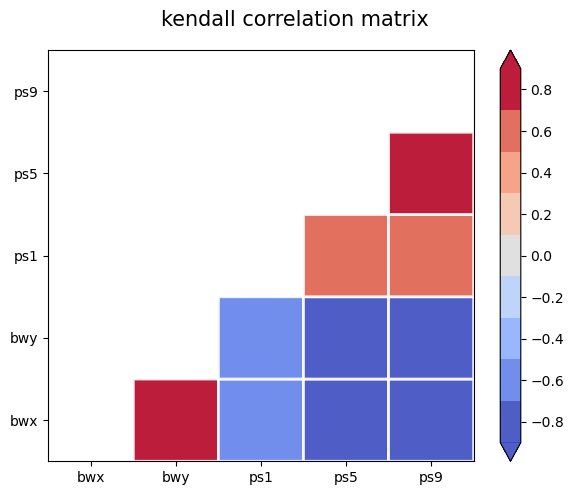

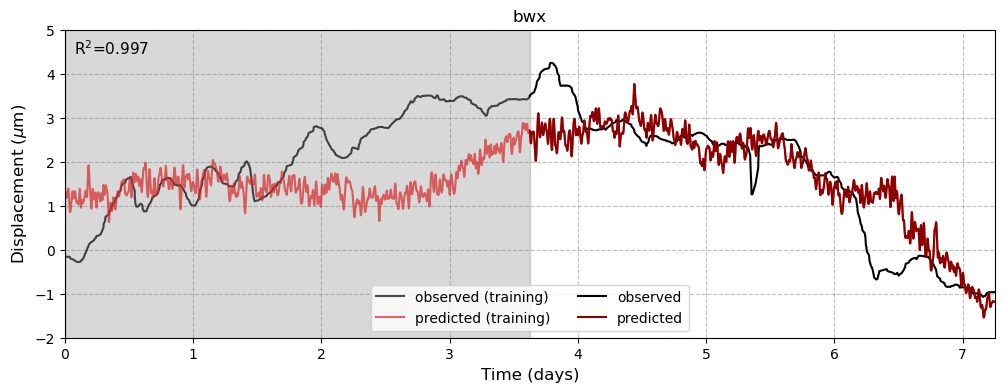

ps1 :  27.67
ps5 :  11.99
ps9 :  -18.98
y0:  1.31


In [114]:

features = ['time', 'bwx', 'bwy', 'bdo', 'ps1', 'ps5', 'ps9', 'mae', 'man', 'hp']
# features = ['time', 'bwx', 'bwy', 'ps1', 'ps5', 'ps9']

df1 = df[features]

# get size of frame
N = df1.shape[0]

# split frame in two parts
df1_part1 = df1.iloc[:int(N/2)]
df1_part2 = df1.iloc[int(N/2):]

# set feature to model
target = "bwy"

# find model with first part of frame
out_y = __find_model(df1, features, target=target, reg="ransac")

# predict data for second part of frame
t_predict_y, d_predict_y = __predict_data(df1_part2, features, out_y['model'], target=target)


fig = __makeplot_corr_matrix(df1_part1, target, m="kendall")

fig = __makeplot2(df1_part1, df1_part2, t_predict_y, d_predict_y, out_y, target);

model = out_y['model']

for i, feat in enumerate(features):
    print(feat, ": ", round(model.estimator_.coef_[i], 2))
print("y0: ", round(model.estimator_.intercept_, 2))


# set feature to model
target = "bwx"

# find model with first part of frame
out_x = __find_model(df1, features, target=target, reg="ransac")

# predict data for second part of frame
t_predict_x, d_predict_x = __predict_data(df1_part2, features, out_x['model'], target=target)


fig = __makeplot_corr_matrix(df1_part1, target, m="kendall")

fig = __makeplot2(df1_part1, df1_part2, t_predict_x, d_predict_x, out_x, target);

model = out_x['model']

for i, feat in enumerate(features):
    print(feat, ": ", round(model.estimator_.coef_[i], 2))
print("y0: ", round(model.estimator_.intercept_, 2))


bdo :  -0.77
ps1 :  -156.28
ps5 :  -13.34
ps9 :  -13.6
mae :  -10.03
man :  -3437921.21
hp :  -3041850.4
y0:  -3.8


In [82]:
def __makeplot_overview(df0, df1, tp, dp, model, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 4), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df0[target], color="k", label="observed (training)", alpha=0.7)
    ax.plot(model['tp']*tscale, model['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax.fill_betweenx([-1000, 1000], df0.time.min()*tscale, df0.time.max()*tscale, color="grey", alpha=0.3)

    ax.plot(df1.time*tscale, df1[target], color="k", label="observed")
    ax.plot(tp*tscale, dp, color="darkred", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=8, fontsize=font-2, ncol=2)

    ax.set_ylabel(f"Displacement (mm)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={out['r2']:.3f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(0, df1.time.max()*tscale)

    ax.set_ylim(-0.01, 0.055)

    ax.set_title(target)

    plt.show();
    return fig

# __makeplot_overview(df0, df1, tp, dp, model, target)


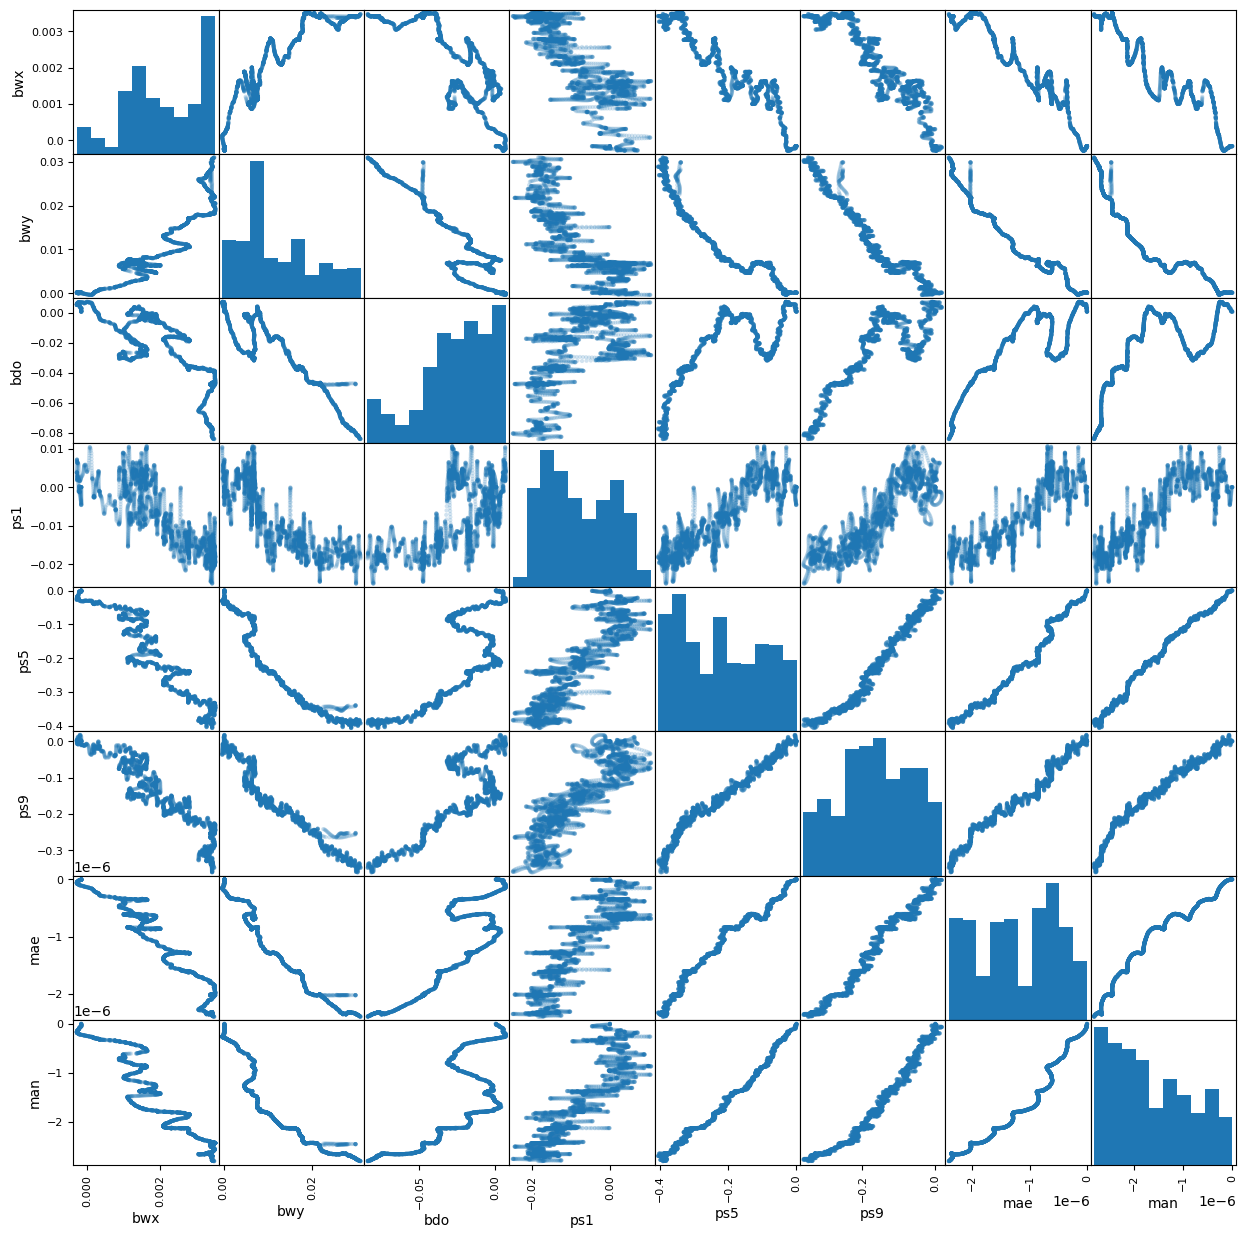

In [57]:
pd.plotting.scatter_matrix(df1_part1,
                           figsize=(15, 15),
                           alpha=0.2,
                           diagonal="hist",
                          );


In [19]:

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import linear_model
# from mpl_toolkits.mplot3d import Axes3D

# ######################################## Data preparation #########################################

# X = df[['mae', 'man']].values.reshape(-1, 2)
# Y = df['fj_bs']

# ######################## Prepare model data point for visualization ###############################

# x = X[:, 0]
# y = X[:, 1]
# z = Y

# x_pred = np.linspace(6, 24, 30)      # range of porosity values
# y_pred = np.linspace(0.93, 2.9, 30)  # range of VR values
# xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
# model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# ################################################ Train #############################################

# ols = linear_model.LinearRegression()
# model = ols.fit(X, Y)
# predicted = model.predict(model_viz)

# ############################################## Evaluate ############################################

# r2 = model.score(X, Y)

# ############################################## Plot ################################################

# plt.style.use('default')

# fig = plt.figure(figsize=(12, 4))

# ax1 = fig.add_subplot(131, projection='3d')
# ax2 = fig.add_subplot(132, projection='3d')
# ax3 = fig.add_subplot(133, projection='3d')

# axes = [ax1, ax2, ax3]

# for ax in axes:
#     ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
#     ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
#     ax.set_xlabel('Porosity (%)', fontsize=12)
#     ax.set_ylabel('VR', fontsize=12)
#     ax.set_zlabel('Gas Prod. (Mcf/day)', fontsize=12)
#     ax.locator_params(nbins=4, axis='x')
#     ax.locator_params(nbins=5, axis='x')

# ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax1.transAxes, color='grey', alpha=0.5)
# ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax2.transAxes, color='grey', alpha=0.5)
# ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax3.transAxes, color='grey', alpha=0.5)

# ax1.view_init(elev=27, azim=112)
# ax2.view_init(elev=16, azim=-51)
# ax3.view_init(elev=60, azim=165)

# fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

# fig.tight_layout();

